# Graph convolutional network

The graph convolutional network is our first GNN for semi-supervised node classification. As opposed to the four classical machine learning classifiers which serve as our baselines, it is capable of taking into account both the graph structure and the node features to predict the value of `segment` for a node.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import NodeClassificationDataset

import json
import os
import os.path as osp
import time

from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def reverse(tuples):
    """
    Reverse a 2-tuple.
    """
    new_tup = tuples[::-1]
    
    return new_tup

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation accuracy is:', df_best[variable].unique()[0])

In [7]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [8]:
def visualize(h, color):
    """
    Visualize the learned embeddings after reducing them to two dimensions.
    """
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    scatter = plt.scatter(z[:, 0], z[:, 1], s=10, c=color, cmap="Set2")
    handles, _ = scatter.legend_elements(prop='colors')
    handles = [handles[i] for i in [2,3,1,0]]
    labels = ['S1', 'S2', 'S3', 'S4']
    return handles, labels

In [9]:
def plot_embeddings(df, filename, save):
    """
    Plot the two-dimensional embeddings in a 5 times 2 plot.
    """
    torch_geometric.seed_everything(12345) 
    
    sns.set_style("whitegrid") 

    plt.figure(figsize=(8, 12))
  
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
    out_mlp = [out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10]
    y = [y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10]
    for i, seed in enumerate(seeds):
        out_mlp[i] = df['embeddings'][i] 
        y[i] = df['y'][i] 
        axes[i] = plt.subplot(5,2,i+1)
        handles, labels = visualize(out_mlp[i], color=y[i])
        axes[i].set_title(f"Run {i+1}: seed {seed}")

    for ax in axes:
        ax.set(xlabel='Dimension 1', ylabel='Dimension 2')
        
    plt.tight_layout() 
        
    legend = plt.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(-0.1, -0.3), frameon=True, title='segment',
                        edgecolor='black')

    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight')

In [10]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid") 
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

We use the [PyTorch Geometric implementation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) of a GCN convolution `GCNConv`. 

With GCNs, the main hyperparameters to tune are:
* `hidden_channels`: size of each hidden sample. It gives us the dimension of the embeddings in the hidden layer. 
* `dropout_prob`: probability of an element to be zeroed.
* `learning_rate`: learning rate of the Adam optimizer.
* `weight_decay`: weight decay (L2 penalty).
* `patience`: number of epochs after which to stop the training process if no improvement in the validation loss has been observed in the meantime.

There are still other hyperparameters that can be tuned, e.g., the optimizer and the depth of the GCN. We do not train them and instead rely on standard choices, e.g., Adam as optimizer. As far as the depth is concerned, we rely on an architecture with only one hidden layer to avoid overfitting, given our relatively small number of 229 nodes. We now perform the hyperparameter tuning using loops.

In [11]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_prob):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=dropout_prob, training=self.training) 
        x = self.conv2(x, edge_index)
        return x
    
def train():
    model.train()
    optimizer.zero_grad()
    out_train=model(data.x, data.edge_index)[data.train_mask]
    loss_train = criterion(out_train, data.y[data.train_mask])
    loss_train.backward() 
    optimizer.step() 
    model.eval()
    out_val = model(data.x, data.edge_index)[data.val_mask]
    loss_val = criterion(out_val, data.y[data.val_mask])
    out_test = model(data.x, data.edge_index)[data.test_mask]
    loss_test = criterion(out_test, data.y[data.test_mask])
    return loss_train, loss_val, loss_test, out_train, out_val, out_test


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return train_acc, val_acc, test_acc 

In [ ]:
start_time = time.time()

gcn_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_accs', 'val_accs', 
                                      'test_accs', 'best_train_losses', 'best_val_losses', 'best_test_losses', 
                                      'best_train_accs', 'best_val_accs', 'best_test_accs', 'mean_best_train_loss', 
                                      'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_acc', 'mean_best_val_acc', 
                                      'mean_best_test_acc', 'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 
                                      'std_best_train_acc', 'std_best_val_acc', 'std_best_test_acc'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for hidden_channels in [8, 16, 32]:
    for dropout_prob in [0.01, 0.05, 0.1, 0.3, 0.5, 0.7]: 
        for learning_rate in [0.001, 0.01, 0.1]:
            for weight_decay in [5e-1, 5e-2, 5e-3, 5e-4, 5e-5, 5e-6]:
                for patience in [3, 5, 10]:
                
                    # Hyperparamter tuning
                    
                    print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

                    parameter_dict = dict({'hidden_channels': hidden_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                    loss_dict = dict() 
                    val_loss_dict = dict() 
                    test_loss_dict = dict() 
                    train_acc_dict = dict() 
                    val_acc_dict = dict() 
                    test_acc_dict = dict() 

                    best_train_loss_dict = dict()
                    best_val_loss_dict = dict()
                    best_test_loss_dict = dict()
                    best_train_acc_dict = dict()
                    best_val_acc_dict = dict()
                    best_test_acc_dict = dict()

                    for i, seed in enumerate(seeds): 

                        torch_geometric.seed_everything(seed) 

                        dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
                        data = dataset[0]
                        
                        model = GCN(hidden_channels = hidden_channels, dropout_prob = dropout_prob)

                        criterion = torch.nn.CrossEntropyLoss()  
                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  
                        
                        loss_list = []
                        val_loss_list = []
                        test_loss_list = []
                        train_acc_list = []
                        val_acc_list = []
                        test_acc_list = []

                        last_loss = 100
                        patience = patience 
                        trigger_times = 0

                        print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                        for epoch in range(1, 101):
                            loss, val_loss, test_loss, out_train, out_val, out_test = train() 
                            train_acc, val_acc, test_acc = test() 
                            loss_list += [loss.item()]
                            val_loss_list += [val_loss.item()]
                            test_loss_list += [test_loss.item()]
                            train_acc_list += [train_acc]
                            val_acc_list += [val_acc]
                            test_acc_list += [test_acc]

                            current_val_loss = val_loss

                            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

                            if current_val_loss <= last_loss:
                                current_best_train_loss = loss.item()
                                current_best_val_loss = current_val_loss.item()
                                current_best_test_loss = test_loss.item()
                                current_best_train_acc = train_acc
                                current_best_val_acc = val_acc
                                current_best_test_acc = test_acc

                                trigger_times = 0
                                print('Trigger times: 0')

                                last_loss = current_val_loss

                            else: 
                                trigger_times += 1
                                print('Trigger times:', trigger_times)

                                if trigger_times >= patience:
                                    print('Early stopping!')
                                    break

                        loss_dict.update({f"{i+1}": loss_list}) 
                        val_loss_dict.update({f"{i+1}": val_loss_list}) 
                        test_loss_dict.update({f"{i+1}": test_loss_list}) 
                        train_acc_dict.update({f"{i+1}": train_acc_list}) 
                        val_acc_dict.update({f"{i+1}": val_acc_list}) 
                        test_acc_dict.update({f"{i+1}": test_acc_list}) 

                        best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                        best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                        best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                        best_train_acc_dict.update({f"{i+1}": current_best_train_acc}) 
                        best_val_acc_dict.update({f"{i+1}": current_best_val_acc}) 
                        best_test_acc_dict.update({f"{i+1}": current_best_test_acc}) 

                        print(current_best_val_loss)

                    data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                    'test_losses': test_loss_dict, 'train_accs': train_acc_dict, 'val_accs': val_acc_dict, 
                                    'test_accs': test_acc_dict, 'best_train_losses': best_train_loss_dict, 
                                    'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                    'best_train_accs': best_train_acc_dict, 'best_val_accs': best_val_acc_dict, 
                                    'best_test_accs': best_test_acc_dict, 
                                    'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                    'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                    'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                    'mean_best_train_acc': mean(best_train_acc_dict.values()), 
                                    'mean_best_val_acc': mean(best_val_acc_dict.values()), 
                                    'mean_best_test_acc': mean(best_test_acc_dict.values()),
                                    'std_best_train_loss': std(best_train_loss_dict.values()), 
                                    'std_best_val_loss': std(best_val_loss_dict.values()), 
                                    'std_best_test_loss': std(best_test_loss_dict.values()), 
                                    'std_best_train_acc': std(best_train_acc_dict.values()), 
                                    'std_best_val_acc': std(best_val_acc_dict.values()), 
                                    'std_best_test_acc': std(best_test_acc_dict.values())}]
                    df_concat = pd.DataFrame(data_concat)
                    gcn_results = pd.concat([gcn_results, df_concat], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to gcn_results.pkl")
gcn_results.to_pickle(f"{route0}/gcn_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [13]:
# Look at results
gcn_results = pd.read_pickle(f"{route0}/gcn_results.pkl") 
gcn_results

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
0,"{'hidden_channels': 8, 'dropout_prob': 0.01, '...","{'1': [1.4395883083343506, 1.4386800527572632,...","{'1': [1.5173479318618774, 1.5147863626480103,...","{'1': [1.523179054260254, 1.520334005355835, 1...","{'1': [0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, ...","{'1': [0.23333333333333334, 0.2333333333333333...","{'1': [0.17829457364341086, 0.1782945736434108...","{'1': 1.3841423988342285, '2': 1.4352689981460...","{'1': 1.423091173171997, '2': 1.26574814319610...","{'1': 1.4168013334274292, '2': 1.3006073236465...",...,1.359933,0.2900,0.276667,0.271318,0.050648,0.047852,0.048295,0.048990,0.162481,0.141290
1,"{'hidden_channels': 8, 'dropout_prob': 0.01, '...","{'1': [1.4395883083343506, 1.4386800527572632,...","{'1': [1.5173479318618774, 1.5147863626480103,...","{'1': [1.523179054260254, 1.520334005355835, 1...","{'1': [0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, ...","{'1': [0.23333333333333334, 0.2333333333333333...","{'1': [0.17829457364341086, 0.1782945736434108...","{'1': 1.3841423988342285, '2': 1.4352689981460...","{'1': 1.423091173171997, '2': 1.26574814319610...","{'1': 1.4168013334274292, '2': 1.3006073236465...",...,1.359933,0.2900,0.276667,0.271318,0.050648,0.047852,0.048295,0.048990,0.162481,0.141290
2,"{'hidden_channels': 8, 'dropout_prob': 0.01, '...","{'1': [1.4395883083343506, 1.4386800527572632,...","{'1': [1.5173479318618774, 1.5147863626480103,...","{'1': [1.523179054260254, 1.520334005355835, 1...","{'1': [0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, ...","{'1': [0.23333333333333334, 0.2333333333333333...","{'1': [0.17829457364341086, 0.1782945736434108...","{'1': 1.3841423988342285, '2': 1.4352689981460...","{'1': 1.423091173171997, '2': 1.26574814319610...","{'1': 1.4168013334274292, '2': 1.3006073236465...",...,1.359933,0.2900,0.276667,0.271318,0.050648,0.047852,0.048295,0.048990,0.162481,0.141290
3,"{'hidden_channels': 8, 'dropout_prob': 0.01, '...","{'1': [1.4395883083343506, 1.4379193782806396,...","{'1': [1.517237901687622, 1.5146172046661377, ...","{'1': [1.5228043794631958, 1.5195419788360596,...","{'1': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...","{'1': [0.23333333333333334, 0.2333333333333333...","{'1': [0.16279069767441862, 0.1550387596899224...","{'1': 1.3315647840499878, '2': 1.4352689981460...","{'1': 1.4411083459854126, '2': 1.2666604518890...","{'1': 1.4200245141983032, '2': 1.3014863729476...",...,1.370911,0.2875,0.276667,0.264341,0.052915,0.056090,0.059994,0.056181,0.174197,0.153967
4,"{'hidden_channels': 8, 'dropout_prob': 0.01, '...","{'1': [1.4395883083343506, 1.4379193782806396,...","{'1': [1.517237901687622, 1.5146172046661377, ...","{'1': [1.5228043794631958, 1.5195419788360596,...","{'1': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...","{'1': [0.23333333333333334, 0.2333333333333333...","{'1': [0.16279069767441862, 0.1550387596899224...","{'1': 1.3315647840499878, '2': 1.4352689981460...","{'1': 1.4411083459854126, '2': 1.2666604518890...","{'1': 1.4200245141983032, '2': 1.3014863729476...",...,1.370911,0.2875,0.276667,0.264341,0.052915,0.056090,0.059994,0.056181,0.174197,0.153967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,"{'hidden_channels': 32, 'dropout_prob': 0.7, '...","{'1': [1.4738401174545288, 1.8770240545272827,...","{'1': [1.7148059606552124, 2.1204071044921875,...","{'1': [1.7761296033859253, 1.9780611991882324,...","{'1': [0.25, 0.25, 0.275, 0.35, 0.275, 0.475, ...","{'1': [0.4666666666666667, 0.0, 0.183333333333...","{'1': [0.4263565891472868, 0.04651162790697674...","{'1': 1.5287503004074097, '2': 1.2626726627349...","{'1': 1.3552604913711548, '2': 1.3655784130096...","{'1': 1.3825241327285767, '2': 1.3979424238204..

## Best hyperparameter combination

In [14]:
filter_best_hyperparameters(gcn_results, 'mean_best_val_acc')

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
586,"{'hidden_channels': 16, 'dropout_prob': 0.5, '...","{'1': [1.3483744859695435, 2.0156893730163574,...","{'1': [2.624082088470459, 1.5336395502090454, ...","{'1': [2.6611201763153076, 1.8097232580184937,...","{'1': [0.275, 0.25, 0.375, 0.3, 0.25, 0.425, 0...","{'1': [0.016666666666666666, 0.366666666666666...","{'1': [0.046511627906976744, 0.263565891472868...","{'1': 2.154740333557129, '2': 1.29446005821228...","{'1': 1.1757944822311401, '2': 1.2529152631759...","{'1': 1.2099227905273438, '2': 1.2459920644760...",...,1.26898,0.4,0.488333,0.46124,0.328739,0.068571,0.053535,0.089443,0.045977,0.058859


In [15]:
print_best_hyperparameters(gcn_results, 'mean_best_val_acc')

The best hyperparameter combination/s is/are:
	 {'hidden_channels': 16, 'dropout_prob': 0.5, 'learning_rate': 0.1, 'weight_decay': 0.0005, 'patience': 5} 
The resulting validation accuracy is: 0.4883333333333334


We see that the best hyperparameter combination leads to the highest mean best validation accuracy of 0.4883. 

So, our best hyperparameter combination is given by:

* hidden_channels = 16
* dropout_prob = 0.5
* learning_rate = 0.1
* weight_decay = 0.0005
* patience = 5

It gives a mean best training accuracy of 0.4000, where the mean best validation accuracy of 0.4883 and the mean best test accuracy of 0.4612 are higher. The standard deviation of the best training accuracies of 0.0894 is rather high, whereas the standard deviations of the best validation accuracies and the best test accuracies are lower, with values of 0.0460 and 0.0589, respectively.

## Visualizations

In [16]:
# Repeat 10 runs of best model

start_time = time.time()

gcn_embeddings = pd.DataFrame(columns=['run', 'embeddings', 'y'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparameters
hidden_channels = 16
dropout_prob = 0.5
learning_rate = 0.1
weight_decay = 5e-4
patience = 5
                    
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed) 

    dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
    data = dataset[0]
    
    model = GCN(hidden_channels=hidden_channels, dropout_prob=dropout_prob)

    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, out_train, out_val, out_test = train() 
        train_acc, val_acc, test_acc = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_out_train = out_train
            current_best_out_val = out_val
            current_best_out_test = out_test
            current_best_train_acc = train_acc
            current_best_val_acc = val_acc
            current_best_test_acc = test_acc
            
            trigger_times = 0
            print('Trigger times: 0')
            
            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break

    print(current_best_val_loss)
    
    embed = [{'run': i+1, 'embeddings': torch.cat((current_best_out_train, current_best_out_val, current_best_out_test), 0), 'y': data.y}]
    embed = pd.DataFrame(embed)
    gcn_embeddings = pd.concat([gcn_embeddings, embed], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to gcn_embeddings.pkl")
gcn_embeddings.to_pickle(f"{route0}/gcn_embeddings.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 16, dropout_prob: 0.5, learning_rate: 0.1, weight_decay: 0.0005, patience: 5}
Run 1 with seed 12345:
Epoch: 001, Train Loss: 1.3484, Val Loss: 2.6241, Test Loss: 2.6611, train acc: 0.2750, val acc: 0.0167, test acc: 0.0465
Trigger times: 0
Epoch: 002, Train Loss: 2.0157, Val Loss: 1.5336, Test Loss: 1.8097, train acc: 0.2500, val acc: 0.3667, test acc: 0.2636
Trigger times: 0
Epoch: 003, Train Loss: 2.1547, Val Loss: 1.1758, Test Loss: 1.2099, train acc: 0.3750, val acc: 0.5167, test acc: 0.4496
Trigger times: 0
Epoch: 004, Train Loss: 1.4565, Val Loss: 1.5768, Test Loss: 1.4561, train acc: 0.3000, val acc: 0.2000, test acc: 0.2713
Trigger times: 1
Epoch: 005, Train Loss: 1.5069, Val Loss: 1.7708, Test Loss: 1.5964, train acc: 0.2500, val acc: 0.1667, test acc: 0.2636
Trigger times: 2
Epoch: 006, Train Loss: 1.4670, Val Loss: 1.8149, Test Loss: 1.6422, train acc: 0.4250, val acc: 0.1167, test acc: 0.1705

Processing...
Done!



Trigger times: 3
Epoch: 007, Train Loss: 1.4166, Val Loss: 1.7340, Test Loss: 1.6106, train acc: 0.3750, val acc: 0.2000, test acc: 0.2016
Trigger times: 4
Epoch: 008, Train Loss: 1.3533, Val Loss: 1.5465, Test Loss: 1.4930, train acc: 0.4000, val acc: 0.1500, test acc: 0.1860
Trigger times: 5
Early stopping!
1.1757944822311401
Run 2 with seed 23456:
Epoch: 001, Train Loss: 1.3907, Val Loss: 1.6025, Test Loss: 1.5636, train acc: 0.3000, val acc: 0.0833, test acc: 0.0233
Trigger times: 0
Epoch: 002, Train Loss: 1.3569, Val Loss: 1.3428, Test Loss: 1.3905, train acc: 0.3250, val acc: 0.2667, test acc: 0.3411


Processing...
Done!


Trigger times: 0
Epoch: 003, Train Loss: 1.5947, Val Loss: 1.9032, Test Loss: 1.8707, train acc: 0.3250, val acc: 0.0833, test acc: 0.0465
Trigger times: 1
Epoch: 004, Train Loss: 1.3563, Val Loss: 1.9444, Test Loss: 1.8724, train acc: 0.3500, val acc: 0.0667, test acc: 0.0543
Trigger times: 2
Epoch: 005, Train Loss: 1.3817, Val Loss: 1.5638, Test Loss: 1.5034, train acc: 0.4250, val acc: 0.1833, test acc: 0.1473
Trigger times: 3
Epoch: 006, Train Loss: 1.3009, Val Loss: 1.3191, Test Loss: 1.2929, train acc: 0.3750, val acc: 0.2667, test acc: 0.3256
Trigger times: 0
Epoch: 007, Train Loss: 1.2945, Val Loss: 1.2529, Test Loss: 1.2460, train acc: 0.4000, val acc: 0.5667, test acc: 0.4496
Trigger times: 0
Epoch: 008, Train Loss: 1.3281, Val Loss: 1.2780, Test Loss: 1.2800, train acc: 0.4250, val acc: 0.5833, test acc: 0.5194
Trigger times: 1
Epoch: 009, Train Loss: 1.2947, Val Loss: 1.3754, Test Loss: 1.3782, train acc: 0.6000, val acc: 0.3500, test acc: 0.3178
Trigger times: 2
Epoch: 010

Processing...
Done!



Trigger times: 0
Epoch: 003, Train Loss: 1.2615, Val Loss: 1.5733, Test Loss: 1.4370, train acc: 0.3750, val acc: 0.2500, test acc: 0.3798
Trigger times: 1
Epoch: 004, Train Loss: 1.3859, Val Loss: 1.2813, Test Loss: 1.2344, train acc: 0.3000, val acc: 0.4833, test acc: 0.4729
Trigger times: 0
Epoch: 005, Train Loss: 1.4142, Val Loss: 1.3135, Test Loss: 1.2637, train acc: 0.3500, val acc: 0.3667, test acc: 0.4806
Trigger times: 1
Epoch: 006, Train Loss: 1.2996, Val Loss: 1.3832, Test Loss: 1.3222, train acc: 0.5000, val acc: 0.2500, test acc: 0.3876
Trigger times: 2
Epoch: 007, Train Loss: 1.2490, Val Loss: 1.4357, Test Loss: 1.3734, train acc: 0.6000, val acc: 0.2833, test acc: 0.3178
Trigger times: 3
Epoch: 008, Train Loss: 1.2092, Val Loss: 1.4602, Test Loss: 1.4113, train acc: 0.5500, val acc: 0.2167, test acc: 0.2403
Trigger times: 4
Epoch: 009, Train Loss: 1.1656, Val Loss: 1.4638, Test Loss: 1.4416, train acc: 0.5250, val acc: 0.2000, test acc: 0.1628
Trigger times: 5
Early sto

Processing...
Done!


Run 4 with seed 45678:
Epoch: 001, Train Loss: 1.3962, Val Loss: 1.5023, Test Loss: 1.4972, train acc: 0.3500, val acc: 0.1000, test acc: 0.0620
Trigger times: 0
Epoch: 002, Train Loss: 1.3334, Val Loss: 1.3704, Test Loss: 1.4835, train acc: 0.3500, val acc: 0.4667, test acc: 0.4109
Trigger times: 0
Epoch: 003, Train Loss: 1.4042, Val Loss: 1.8395, Test Loss: 1.9032, train acc: 0.4250, val acc: 0.0833, test acc: 0.0620
Trigger times: 1
Epoch: 004, Train Loss: 1.2417, Val Loss: 1.6454, Test Loss: 1.5867, train acc: 0.4500, val acc: 0.2000, test acc: 0.2093
Trigger times: 2
Epoch: 005, Train Loss: 1.2122, Val Loss: 1.4481, Test Loss: 1.3915, train acc: 0.4250, val acc: 0.2667, test acc: 0.3643
Trigger times: 3
Epoch: 006, Train Loss: 1.1434, Val Loss: 1.3150, Test Loss: 1.3266, train acc: 0.5500, val acc: 0.2500, test acc: 0.2713
Trigger times: 0
Epoch: 007, Train Loss: 1.0862, Val Loss: 1.2815, Test Loss: 1.3478, train acc: 0.5250, val acc: 0.4000, test acc: 0.2868
Trigger times: 0
Epoc

Processing...
Done!


Epoch: 001, Train Loss: 1.3826, Val Loss: 1.9675, Test Loss: 1.9264, train acc: 0.2750, val acc: 0.0333, test acc: 0.0775
Trigger times: 0
Epoch: 002, Train Loss: 1.5829, Val Loss: 1.2595, Test Loss: 1.2661, train acc: 0.2750, val acc: 0.4333, test acc: 0.4651
Trigger times: 0
Epoch: 003, Train Loss: 1.3988, Val Loss: 1.3585, Test Loss: 1.3355, train acc: 0.3000, val acc: 0.2167, test acc: 0.2636
Trigger times: 1
Epoch: 004, Train Loss: 1.3576, Val Loss: 1.4758, Test Loss: 1.4208, train acc: 0.3000, val acc: 0.2333, test acc: 0.2868
Trigger times: 2
Epoch: 005, Train Loss: 1.2744, Val Loss: 1.5569, Test Loss: 1.4687, train acc: 0.4000, val acc: 0.0667, test acc: 0.1628
Trigger times: 3
Epoch: 006, Train Loss: 1.2431, Val Loss: 1.4613, Test Loss: 1.3610, train acc: 0.4000, val acc: 0.1167, test acc: 0.2481
Trigger times: 4
Epoch: 007, Train Loss: 1.1954, Val Loss: 1.4204, Test Loss: 1.3567, train acc: 0.5250, val acc: 0.1667, test acc: 0.2946
Trigger times: 5
Early stopping!
1.259485840

Processing...
Done!


Run 6 with seed 54321:
Epoch: 001, Train Loss: 1.3698, Val Loss: 1.6904, Test Loss: 1.8665, train acc: 0.2500, val acc: 0.0667, test acc: 0.0310
Trigger times: 0
Epoch: 002, Train Loss: 1.4485, Val Loss: 1.3037, Test Loss: 1.3387, train acc: 0.3250, val acc: 0.4333, test acc: 0.3566
Trigger times: 0
Epoch: 003, Train Loss: 1.3327, Val Loss: 1.2774, Test Loss: 1.2988, train acc: 0.3000, val acc: 0.4667, test acc: 0.5039
Trigger times: 0
Epoch: 004, Train Loss: 1.3800, Val Loss: 1.2614, Test Loss: 1.2978, train acc: 0.3000, val acc: 0.4667, test acc: 0.5116
Trigger times: 0
Epoch: 005, Train Loss: 1.2865, Val Loss: 1.2525, Test Loss: 1.3063, train acc: 0.3750, val acc: 0.5333, test acc: 0.4031
Trigger times: 0
Epoch: 006, Train Loss: 1.2595, Val Loss: 1.2454, Test Loss: 1.3250, train acc: 0.4250, val acc: 0.5000, test acc: 0.3721
Trigger times: 0
Epoch: 007, Train Loss: 1.2348, Val Loss: 1.2393, Test Loss: 1.3443, train acc: 0.4250, val acc: 0.5667, test acc: 0.3876
Trigger times: 0
Epoc

Processing...
Done!


Run 7 with seed 65432:
Epoch: 001, Train Loss: 1.3887, Val Loss: 1.3972, Test Loss: 1.4722, train acc: 0.2500, val acc: 0.4500, test acc: 0.4341
Trigger times: 0
Epoch: 002, Train Loss: 1.5592, Val Loss: 1.7066, Test Loss: 1.7108, train acc: 0.2750, val acc: 0.0667, test acc: 0.0233
Trigger times: 1
Epoch: 003, Train Loss: 1.3878, Val Loss: 1.7795, Test Loss: 1.7309, train acc: 0.4000, val acc: 0.0833, test acc: 0.1008
Trigger times: 2
Epoch: 004, Train Loss: 1.4181, Val Loss: 1.5686, Test Loss: 1.5400, train acc: 0.5500, val acc: 0.2667, test acc: 0.2403
Trigger times: 3
Epoch: 005, Train Loss: 1.3406, Val Loss: 1.3236, Test Loss: 1.3451, train acc: 0.6000, val acc: 0.3833, test acc: 0.3333
Trigger times: 0
Epoch: 006, Train Loss: 1.2607, Val Loss: 1.2259, Test Loss: 1.2651, train acc: 0.3750, val acc: 0.5333, test acc: 0.4884
Trigger times: 0
Epoch: 007, Train Loss: 1.2870, Val Loss: 1.2315, Test Loss: 1.2915, train acc: 0.3500, val acc: 0.5167, test acc: 0.4884
Trigger times: 1
Epoc

Processing...
Done!


Epoch: 003, Train Loss: 1.3137, Val Loss: 1.5978, Test Loss: 1.5569, train acc: 0.4500, val acc: 0.1667, test acc: 0.2016
Trigger times: 1
Epoch: 004, Train Loss: 1.2822, Val Loss: 1.4924, Test Loss: 1.4545, train acc: 0.4500, val acc: 0.2000, test acc: 0.1938
Trigger times: 2
Epoch: 005, Train Loss: 1.2080, Val Loss: 1.3393, Test Loss: 1.3128, train acc: 0.3750, val acc: 0.3000, test acc: 0.3101
Trigger times: 0
Epoch: 006, Train Loss: 1.1675, Val Loss: 1.4031, Test Loss: 1.3632, train acc: 0.4500, val acc: 0.1500, test acc: 0.2481
Trigger times: 1
Epoch: 007, Train Loss: 1.1247, Val Loss: 1.6745, Test Loss: 1.6019, train acc: 0.4500, val acc: 0.1333, test acc: 0.1938
Trigger times: 2
Epoch: 008, Train Loss: 1.2233, Val Loss: 1.3269, Test Loss: 1.2721, train acc: 0.4750, val acc: 0.4167, test acc: 0.4574
Trigger times: 0
Epoch: 009, Train Loss: 1.0663, Val Loss: 1.2374, Test Loss: 1.1784, train acc: 0.4500, val acc: 0.4167, test acc: 0.4961
Trigger times: 0
Epoch: 010, Train Loss: 1.1

Processing...
Done!


Trigger times: 0
Epoch: 002, Train Loss: 1.4400, Val Loss: 1.4487, Test Loss: 1.4621, train acc: 0.2750, val acc: 0.0667, test acc: 0.0775
Trigger times: 1
Epoch: 003, Train Loss: 1.3692, Val Loss: 1.4937, Test Loss: 1.4458, train acc: 0.2750, val acc: 0.0333, test acc: 0.0388
Trigger times: 2
Epoch: 004, Train Loss: 1.3828, Val Loss: 1.4373, Test Loss: 1.4329, train acc: 0.3000, val acc: 0.0833, test acc: 0.0775
Trigger times: 3
Epoch: 005, Train Loss: 1.3559, Val Loss: 1.4158, Test Loss: 1.4473, train acc: 0.3750, val acc: 0.1500, test acc: 0.1163
Trigger times: 4
Epoch: 006, Train Loss: 1.3211, Val Loss: 1.3456, Test Loss: 1.3814, train acc: 0.4000, val acc: 0.3833, test acc: 0.2481
Trigger times: 0
Epoch: 007, Train Loss: 1.3162, Val Loss: 1.2868, Test Loss: 1.3313, train acc: 0.4500, val acc: 0.4500, test acc: 0.2481
Trigger times: 0
Epoch: 008, Train Loss: 1.2853, Val Loss: 1.2546, Test Loss: 1.3128, train acc: 0.4750, val acc: 0.4833, test acc: 0.2946
Trigger times: 0
Epoch: 009

Processing...
Done!


Trigger times: 0
Epoch: 003, Train Loss: 1.5889, Val Loss: 1.3678, Test Loss: 1.3718, train acc: 0.4000, val acc: 0.4333, test acc: 0.5116
Trigger times: 0
Epoch: 004, Train Loss: 1.4245, Val Loss: 1.4402, Test Loss: 1.4718, train acc: 0.4500, val acc: 0.2667, test acc: 0.2016
Trigger times: 1
Epoch: 005, Train Loss: 1.3630, Val Loss: 1.5953, Test Loss: 1.5701, train acc: 0.3500, val acc: 0.1167, test acc: 0.1473
Trigger times: 2
Epoch: 006, Train Loss: 1.3396, Val Loss: 1.6356, Test Loss: 1.5627, train acc: 0.3500, val acc: 0.1833, test acc: 0.1860
Trigger times: 3
Epoch: 007, Train Loss: 1.3299, Val Loss: 1.5755, Test Loss: 1.4730, train acc: 0.4000, val acc: 0.2167, test acc: 0.2481
Trigger times: 4
Epoch: 008, Train Loss: 1.3131, Val Loss: 1.4774, Test Loss: 1.3664, train acc: 0.5000, val acc: 0.2333, test acc: 0.2248
Trigger times: 5
Early stopping!
1.3678333759307861
saving file corresponding to gcn_embeddings.pkl
0 hours 0.07441 minutes


In [17]:
# Look at embeddings
gcn_embeddings = pd.read_pickle(f"{route0}/gcn_embeddings.pkl") 
gcn_embeddings

,run,embeddings,y
0,1,"[[tensor(-0.2403, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
1,2,"[[tensor(0.0310, grad_fn=<UnbindBackward>), te...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
2,3,"[[tensor(-0.1082, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
3,4,"[[tensor(-0.2080, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
4,5,"[[tensor(0.4879, grad_fn=<UnbindBackward>), te...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
5,6,"[[tensor(0.0372, grad_fn=<UnbindBackward>), te...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
6,7,"[[tensor(-0.1949, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
7,8,"[[tensor(-0.1903, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
8,9,"[[tensor(-0.1296, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
9,10,"[[tensor(0.6008, grad_fn=<UnbindBackward>), te...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."


To get a better impression of our model, let us look at a summary of our graph convolutional network.

In [18]:
model

GCN(
  (conv1): GCNConv(64, 16)
  (conv2): GCNConv(16, 4)
)

In [19]:
model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
          conv1.bias                       [16]              16
    conv1.lin.weight                   [16, 64]            1024
          conv2.bias                        [4]               4
    conv2.lin.weight                    [4, 16]              64
----------------------------------------------------------------
Total params: 1108
Trainable params: 1108
Non-trainable params: 0


### Visualization of learned embeddings

Now our goal is to visualize the embeddings learned in the 10 runs for the best hyperparameter combination. Note that the final embeddings of the graph convolutional network are four-dimensional and that these embeddings are now reduced to two dimensions to be able to visualize them.

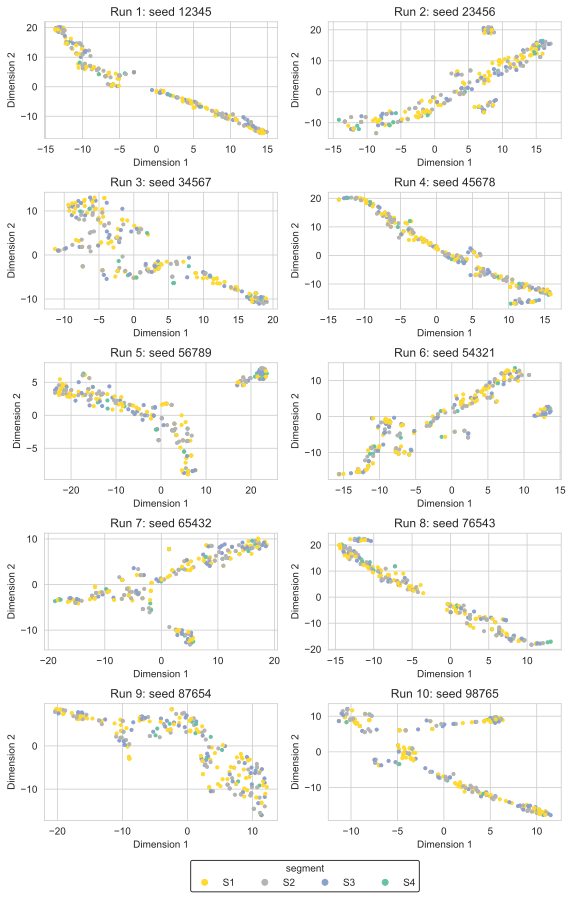

In [20]:
plot_embeddings(gcn_embeddings, 'gcn_scatterplots', True)

### Visualization of losses and accuracies

Finally, we take a look at the losses and accuracies in the training set, validation set and test set for the 10 runs for the best hyperparameter combination.

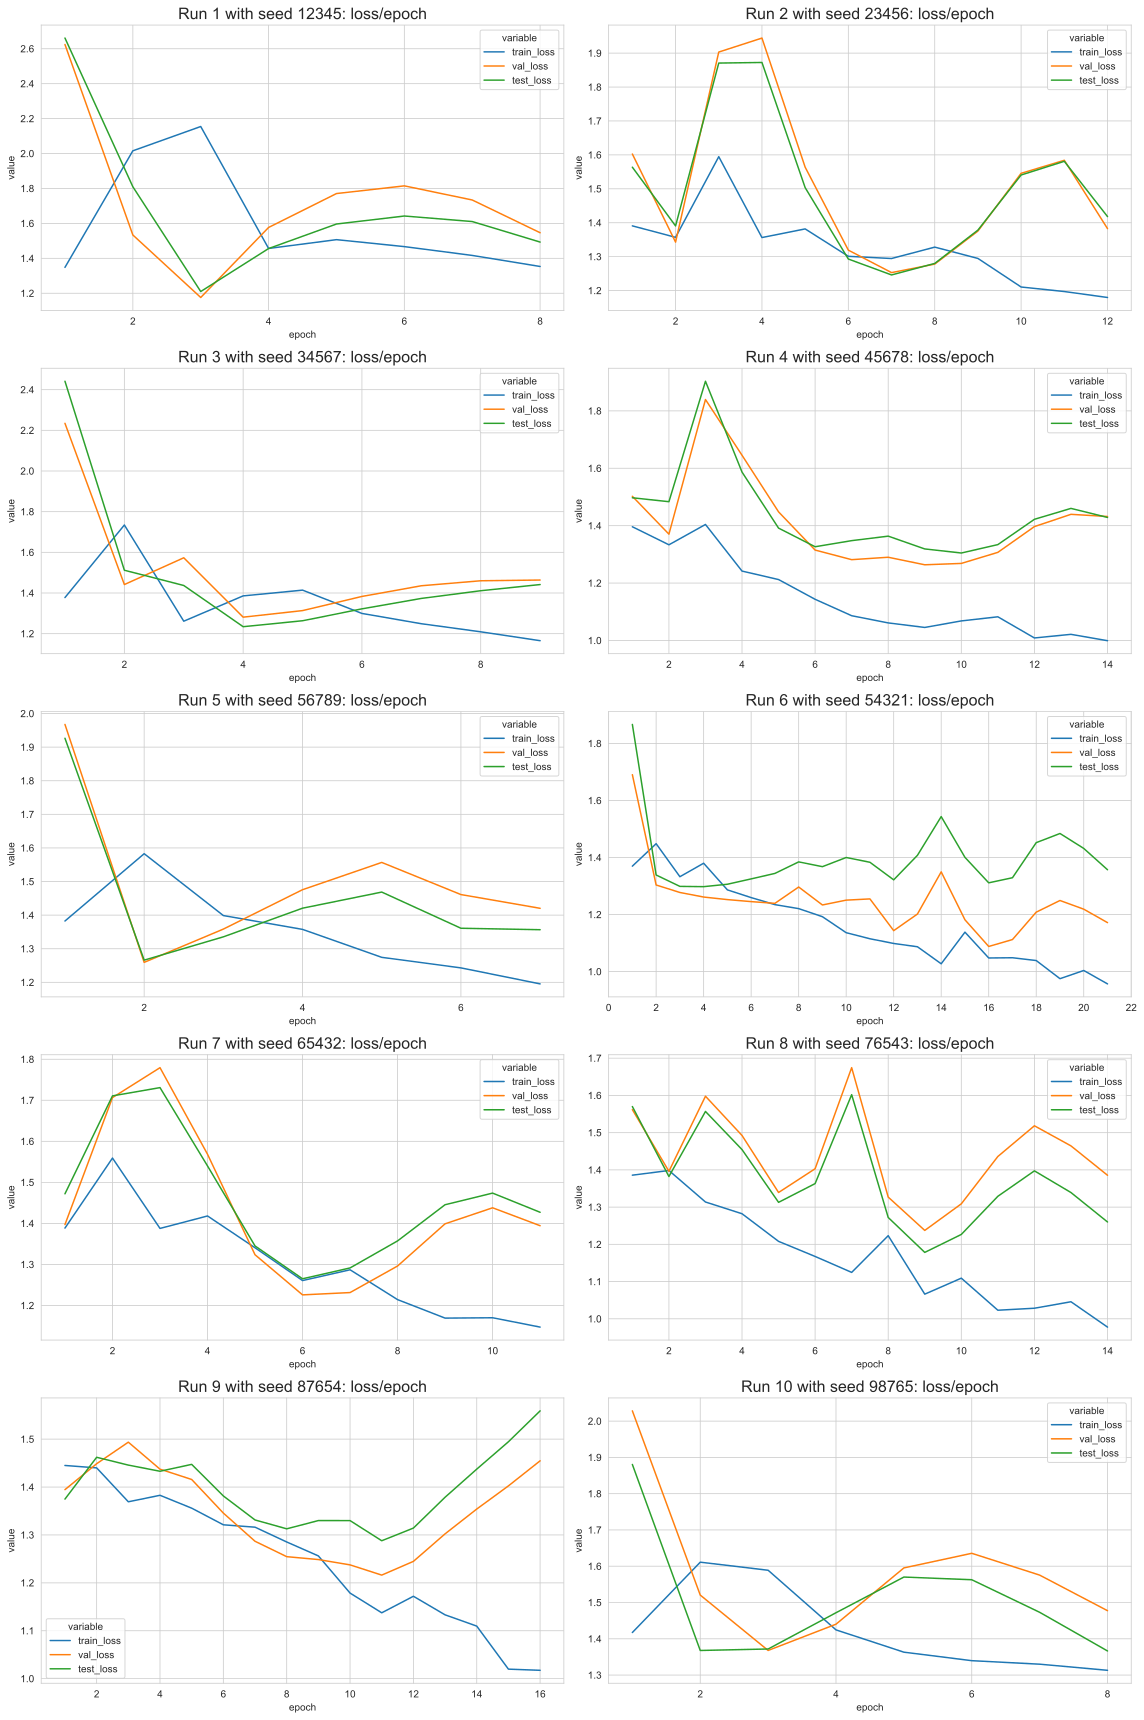

In [21]:
plot_losses_and_accuracies('loss', gcn_results, 586, 2.0, 'gcn_loss', True)

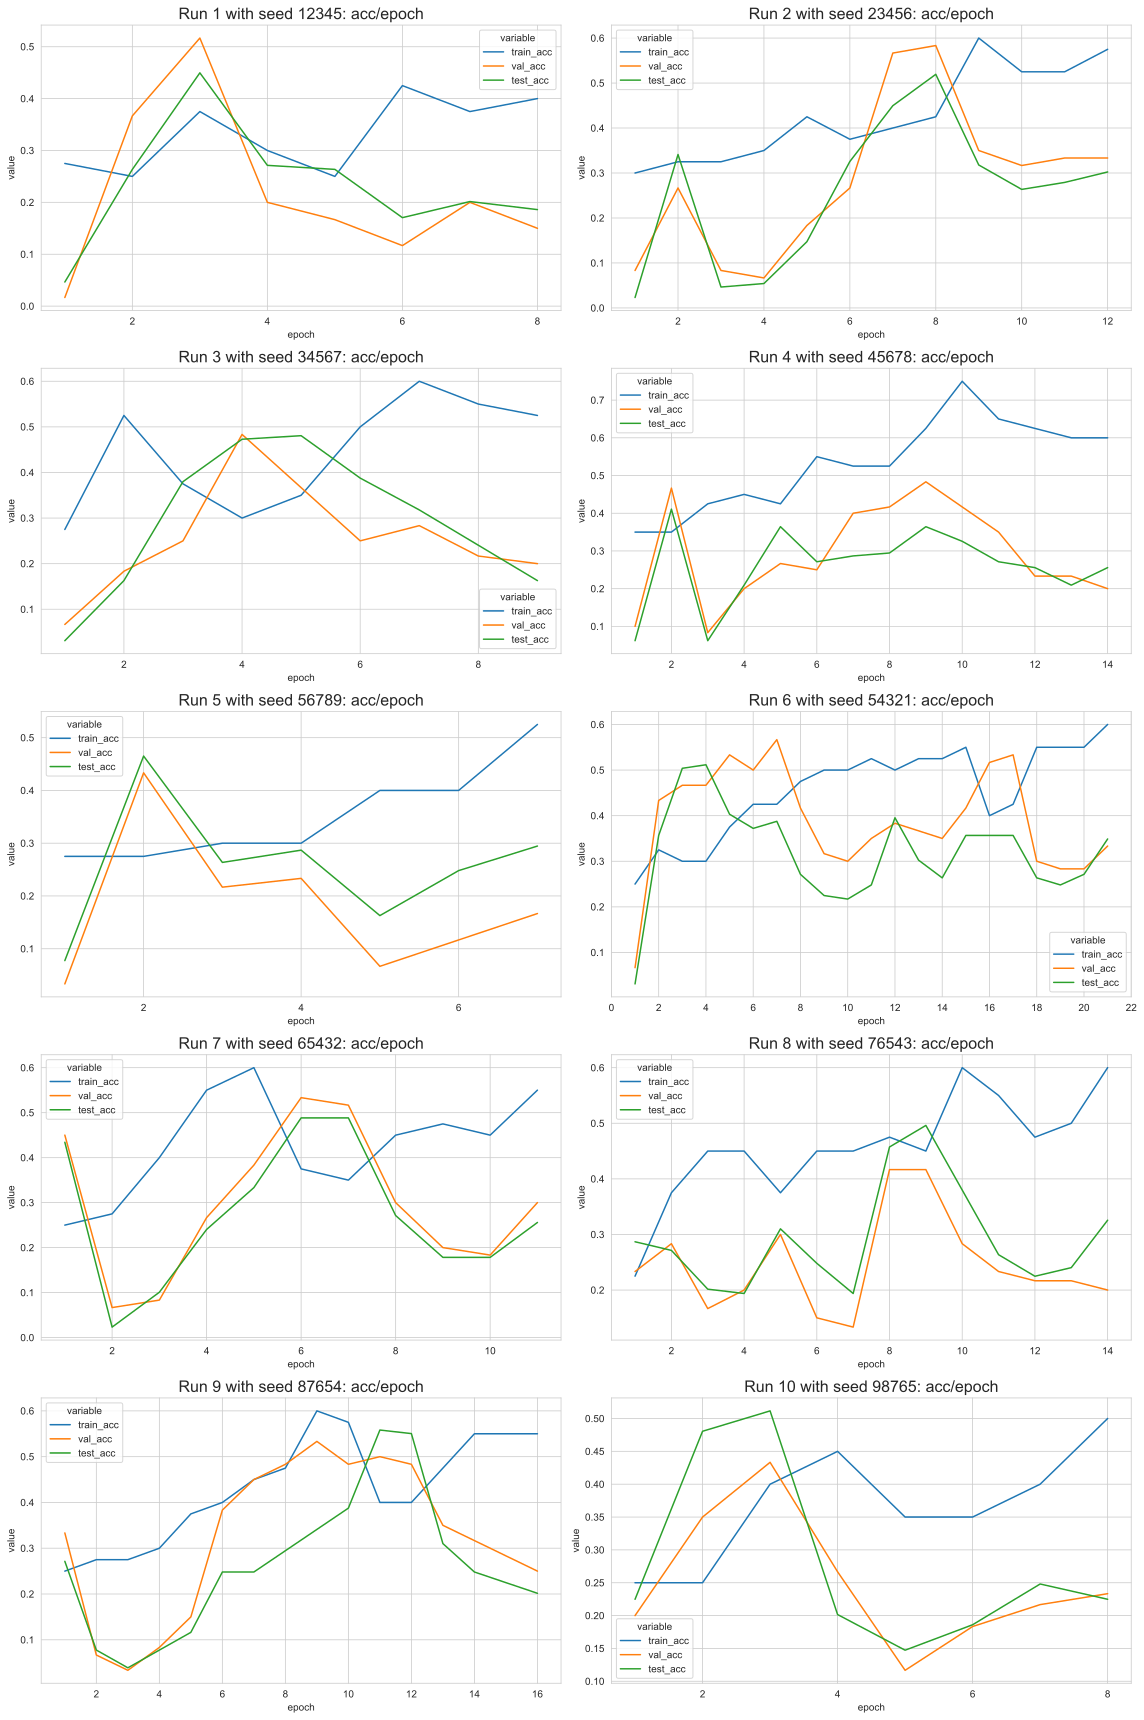

In [22]:
plot_losses_and_accuracies('acc', gcn_results, 586, 2.0, 'gcn_acc', True)